In [169]:
import ltspice 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np 
import os  
from PyLTSpice.LTSpice_RawRead import LTSpiceRawRead
import pandas as pd
from os import listdir
import sys
from scipy import interpolate 
from scipy.optimize import curve_fit
import scipy.constants as cons
import h5py
import matplotlib.ticker as ticker
from datetime import datetime
from scipy import asarray as ar,exp
from scipy.signal import savgol_filter

In [170]:
atomic_mass =  1.66053906660* 10**(-27)
m_Ca = (39.96259087)*atomic_mass
##
## Simulation values of Electric fields due to 1V on electrodes 
##

x_axis =[1.26283104e-02 , 2.84553925e-03, -1.73513234e-01, -2.33007065e+02, 2.31467575e+02, 6.34518683e-01, 8.86796176e-01,
-5.73204041e+01, 5.68283157e+01, 1.36016592e-01, 1.57674611e-01]

y_axis = [3.244789123535156250e+01,-3.232956314086914062e+01, -7.539201974868774414e-01, -2.477783896028995514e-02, -7.491269707679748535e-02, 5.387742309570312500e+02, -5.378519897460937500e+02,7.722367998212575912e-03, -3.334570792503654957e-04, 6.302957763671875000e+02, -6.301546630859375000e+02]

z_axis = [-1.459924411773681641e+01,-1.447677612304687500e+01,7.160206909179687500e+02,1.169928665161132812e+02,1.169021453857421875e+02,4.762999267578125000e+02,4.743959350585937500e+02,-1.385639762878417969e+01,-1.369526290893554688e+01,-9.236360473632812500e+02,-9.233392944335937500e+02]


In [171]:
def squared(x):
    return(x**2)

def SpectralNoiseFormula(sdAmplf, sdAllpass ,gainAllpass):
    s_tot = (sdAmplf**2)*(gainAllpass**2) + (sdAllpass**2)
    return  s_tot 

def sqrtSpectralNoiseFormula(sdAmplf, sdAllpass ,gainAllpass):
    s_tot = ((sdAmplf**2)*(gainAllpass**2) + (sdAllpass**2))**(1/2)
    return  s_tot 

In [172]:
folder_path = "measured/"
#ethernet grounding with dac
eth = pd.read_csv(folder_path +"ethernetcon.csv",delimiter = "\t")
noeth = pd.read_csv(folder_path +"ethernetdisc.csv",delimiter = "\t")
#fb on OCB
fb = pd.read_csv(folder_path +"fbpcb.csv",delimiter = "\t")

#dac grounding
"""
fb_seperate = pd.read_csv(folder_path +"FB21_7.csv",delimiter = "\t")
rc = pd.read_csv(folder_path +"RC21_7.csv",delimiter = "\t")
rc_board = pd.read_csv(folder_path +"RC_PCB_21_7.csv",delimiter = "\t")
"""
gnd = pd.read_csv(folder_path +"TERM_21_7.csv",delimiter = "\t")  

#new grounding 
fb_seperate = pd.read_csv(folder_path +"FB21_7_G.csv",delimiter = "\t")
rc = pd.read_csv(folder_path +"RC21_7_G.csv",delimiter = "\t")
rc_board= pd.read_csv(folder_path +"RC_PCB_G_21_7.csv",delimiter = "\t")



fb_converted =[]
fb_seperate_converted =[]
rc_converted = []
rc_board_converted = []
gnd_converted = []
eth_converted = []
noeth_converted = []

def conversion(valuedBm): 
    rbw = 100
    impedance = 50
    a = np.sqrt((impedance*0.001/rbw)*(10**((valuedBm)/10)))  
    return a


feq_meas = list(fb.iloc[:,0]) # np.array(list(chasis.iloc[:,0]))
fb_mag = list(fb.iloc[:,1])
fb_seperate_mag = list(fb_seperate.iloc[:,1])
rc_mag = list(rc.iloc[:,1])
rc_board_mag = list(rc_board.iloc[:,1])
gnd_mag = list(gnd.iloc[:,1])
eth_mag = list(eth.iloc[:,1])
noeth_mag = list(noeth.iloc[:,1])


for i in range(0, len(feq_meas)):
    fb_converted.append(conversion(fb_mag[i]))
    fb_seperate_converted.append(conversion(fb_seperate_mag[i]))
    rc_converted.append(conversion(rc_mag[i]))
    rc_board_converted.append(conversion(rc_board_mag[i]))
    gnd_converted.append(conversion(gnd_mag[i]))
    eth_converted.append(conversion(eth_mag[i]))
    noeth_converted.append(conversion(noeth_mag[i]))

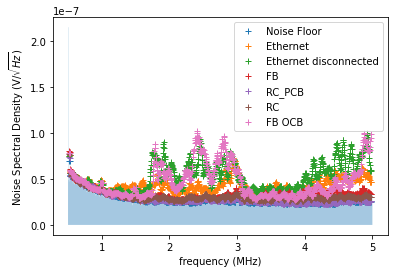

In [200]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, ax = plt.subplots()

ax.plot(moving_average(feq_meas, 10), moving_average(gnd_converted, 10),'+' ,label='Noise Floor')
ax.fill_between(feq_meas, gnd_converted,step="pre", alpha=0.4)

ax.plot(moving_average(feq_meas,10), moving_average(eth_converted,10), '+',label='Ethernet')
ax.plot(moving_average(feq_meas,10), moving_average(noeth_converted,10), '+',label='Ethernet disconnected')
ax.plot(moving_average(feq_meas,10), moving_average(fb_seperate_converted,10), '+',label='FB')
ax.plot(moving_average(feq_meas,10), moving_average(rc_board_converted,10), '+',label='RC_PCB')
ax.plot(moving_average(feq_meas,10), moving_average(rc_converted,10), '+',label='RC')
ax.plot(moving_average(feq_meas,10),moving_average(fb_converted,10), '+',label="FB OCB")
ax.set_xlabel('frequency (MHz)')
ax.set_ylabel('Noise Spectral Density (V/$\sqrt{Hz}$)')
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
ax.xaxis.set_major_formatter(ticks)
#plt.yscale('log',base=10) 
plt.legend()
plt.show()

In [201]:
1*10**(-7)*10**(6)

0.09999999999999999

In [174]:
rawFBfeed = ltspice.Ltspice('actualfilterfeedthru.raw')
rawFBfeed.parse()
#FB at Feedthru
noise_rawFBfeed = rawFBfeed.get_data('V(onoise)')
gain_rawFBfeed = rawFBfeed.get_data('gain')
freq = rawFBfeed.get_data('frequency')

In [175]:
fb_noise = []
fb_seperate_noise = []
rc_noise = []
rc_pcb_noise = []
#fastino_noise = []
eth_noise = []
noeth_noise = []
gnd_noise = []
frequency_array_meas = []

for j in range(0, len(feq_meas)): 
    frequency_meas = feq_meas[j]
    frequency_array_meas.append(frequency_meas) 
    noise_interpolated = np.interp(frequency_meas, freq, noise_rawFBfeed)
    gain_interpolated = np.interp(frequency_meas, freq, gain_rawFBfeed)

    
    fb_noise.append(SpectralNoiseFormula(fb_converted[j],noise_interpolated,gain_interpolated))
    fb_seperate_noise.append(SpectralNoiseFormula(fb_seperate_converted[j],noise_interpolated,gain_interpolated))
    rc_pcb_noise.append(SpectralNoiseFormula(rc_board_converted[j],noise_interpolated,gain_interpolated))
    rc_noise.append(SpectralNoiseFormula(rc_converted[j],noise_interpolated,gain_interpolated))
    gnd_noise.append(SpectralNoiseFormula(gnd_converted[j],noise_interpolated,gain_interpolated))


    eth_noise.append(SpectralNoiseFormula(eth_converted[j],noise_interpolated,gain_interpolated))
    noeth_noise.append(SpectralNoiseFormula(noeth_converted[j],noise_interpolated,gain_interpolated))
    


In [176]:
frequency_x = np.array([0.9001789823391073,
0.9437795729477444,
1.0252114885676957,
1.0638987887232565,
1.100821295451343,
1.135977488147777,
1.236995745603602,
1.267927434665372,
1.2996137379209354,
1.3586571602600996,
1.415701554619007])
frequency_x = frequency_x*1.e6
HR_x = [69.24038869733933,
59.96234042377333,
47.2138851604604,
46.87063426697047,
37.475966505562255,
39.00563001250567,
31.281636157386867,
31.808799176921827,
27.730829872254766,
26.928522292376087,
21.589198655440015]
frequency_y =np.array([1.636717664073176,
1.7536338634632855,
1.8203482753879003,
1.8779897626938327,
1.9564506050049877,
2.017706938996064,
2.059106057300692,
2.0685732477088816,
2.1263569835276694,
2.131024608733191,
2.1777966511759748,
2.2606404448466964,
2.264803303855524,
2.3094745527924125,
2.3281001503012906,
2.36837062575528,
2.3849040793683076,
2.510028803327298,
2.5699035468931064,
2.6503880938410074,
2.656269565447679,
2.676090733502241,
2.712717466840009,
2.786931815957286,
2.8008107026471483,
2.8546191443380193,
2.941854418671944,
3.1005188732475477,
3.1030324705203385,
3.1775296269353306,
3.258474391947965,
3.2683624563390397])
frequency_y = frequency_y*1.e6
HR_y = [83.1316978538842,
87.1181096291914,
96.74398456185432,
98.05476403643297,
317.32366620027733,
184.53757871196763,
89.84257107969407,
127.15788475447035,
63.53830073478075,
63.643521576931846,
101.92438891901317,
144.53381830750342,
108.79548718749002,
40.88811015418392,
93.67572781724047,
40.6244462378223,
61.72556842189231,
44.93652605958764,
39.547346977122494,
29.256747851191978,
22.094067716037976,
23.018262555123087,
47.767145589454685,
31.405541907047905,
37.38933429187226,
49.175929249922696,
26.369913258807475,
27.22494199890959,
19.151001987434437,
25.57834629527803,
29.89083016253065,
15.238538324671833]
frequency_z = np.array([ 1.3006531228324631,
1.4219998106805296,
1.528808904028959,
1.529038593885789,
1.6222867469610052,
1.6526144143251333,
1.6716286167317251,
1.7354391725138367,
1.7534472255609748,
1.7862289383704435,
1.813798119863976,
1.8661076549427857,
1.8976857082214083,
1.9511326528103774,
2.014522358507832,
2.018349014787159,
2.085631569092366,
2.1197646193723507,
2.143368791558399,
2.167159695408431,
2.22902072210736,
2.299057617348615,
2.3062992387009165,
2.3691792467435486,
2.4523265691277363,
2.4598293211825086,
2.4784592798352842,
2.5201431695313983,
2.5996644217703304,
2.614229943490361,
2.674374926568465,
2.763042218359706,
2.7706925100325894,
2.849412255065737,
2.931007955353169,
2.931931383238576,
3.0122735535852994,
3.0964691255211214,
3.1060919441834898 ])
frequency_z = frequency_z*1.e6
HR_z = [530.1174631931104,
148.96534086729986,
142.1574966038835,
215.66264929298882,
162.80523487069573,
151.43439004659754,
149.82375034292608,
225.8380211737235,
268.3532552385673,
261.4922082743787,
448.10381245925356,
114.14022557165268,
207.96595022296438,
271.6804507964738,
265.81229657232694,
291.2934618390539,
159.80109896106026,
209.86404562850345,
178.04778145324485,
192.28289681582436,
231.68656211013186,
136.27946983090325,
168.7843622674747,
288.9218416924599,
162.87755055013187,
127.74672490746997,
158.21131280390307,
87.3006801872009,
66.6793027541329,
97.72298669444105,
61.037860461430995,
75.01722966537993,
49.0495081906319,
150.88086399682203,
67.6944393534121,
87.19541684492229,
62.67221240699694,
41.830974475958676,
28.328439593766962]

In [177]:
SE_measfb_z = []
heating_rates_measfb_z = []
SE_measfb_x = []
heating_rates_measfb_x = []
SE_measfb_y = []
heating_rates_measfb_y = []

SE_measfb_seperate_z = []
heating_rates_measfb_seperate_z = []
SE_measfb_seperate_x = []
heating_rates_measfb_seperate_x = []
SE_measfb_seperate_y = []
heating_rates_measfb_seperate_y = []

SE_meas_rc_pcb_z = []
heating_rates_meas_rc_pcb_z = []
SE_meas_rc_pcb_x = []
heating_rates_meas_rc_pcb_x = []
SE_meas_rc_pcb_y = []
heating_rates_meas_rc_pcb_y = []

SE_meas_rc_z = []
heating_rates_meas_rc_z = []
SE_meas_rc_x = []
heating_rates_meas_rc_x = []
SE_meas_rc_y = []
heating_rates_meas_rc_y = []

SE_gnd_meas_z = []
heating_rates_gnd_meas_z = []
SE_gnd_meas_x = []
heating_rates_gnd_meas_x = []
SE_gnd_meas_y = []
heating_rates_gnd_meas_y = []

SE_meas_eth_z = []
heating_rates_meas_eth_z = []
SE_meas_eth_x = []
heating_rates_meas_eth_x = []
SE_meas_eth_y = []
heating_rates_meas_eth_y = []

SE_meas_noeth_z = []
heating_rates_meas_noeth_z = []
SE_meas_noeth_x = []
heating_rates_meas_noeth_x = []
SE_meas_noeth_y = []
heating_rates_meas_noeth_y = []


## conversion
def SEcalc1axs1elec(Volt_sd, V_E_scaling):
    return Volt_sd *(V_E_scaling)**(2)

for i in range(0, len(frequency_array_meas)):
    z_summe_rc = 0
    z_summe_gnd = 0
    z_summe_fb = 0
    z_summe_fbsep= 0
    z_summe_rcpcb= 0
    z_summe_eth= 0
    z_summe_noeth= 0


    x_summe_rc = 0
    x_summe_fb = 0
    x_summe_fbsep= 0
    x_summe_gnd = 0
    x_summe_rcpcb= 0
    x_summe_eth= 0
    x_summe_noeth= 0

    y_summe_rc = 0
    y_summe_fb = 0
    y_summe_fbsep= 0
    y_summe_rcpcb= 0
    y_summe_gnd = 0   
    y_summe_eth= 0
    y_summe_noeth= 0


    for j in range(len(z_axis)):
        z_summe_rc += SEcalc1axs1elec(rc_noise[i],z_axis[j])
        z_summe_fb += SEcalc1axs1elec(fb_noise[i],z_axis[j])
        z_summe_fbsep += SEcalc1axs1elec(fb_seperate_noise[i],z_axis[j]) 
        z_summe_rcpcb += SEcalc1axs1elec(rc_pcb_noise[i],z_axis[j])
        z_summe_gnd += SEcalc1axs1elec(gnd_noise[i],z_axis[j])
        z_summe_eth += SEcalc1axs1elec(eth_noise[i],z_axis[j]) 
        z_summe_noeth += SEcalc1axs1elec(noeth_noise[i],z_axis[j])

        x_summe_rc += SEcalc1axs1elec(rc_noise[i],x_axis[j])
        x_summe_fb += SEcalc1axs1elec(fb_noise[i],x_axis[j])
        x_summe_fbsep += SEcalc1axs1elec(fb_seperate_noise[i],x_axis[j]) 
        x_summe_rcpcb += SEcalc1axs1elec(rc_pcb_noise[i],x_axis[j])
        x_summe_gnd += SEcalc1axs1elec(gnd_noise[i],x_axis[j])
        x_summe_eth += SEcalc1axs1elec(eth_noise[i],x_axis[j]) 
        x_summe_noeth += SEcalc1axs1elec(noeth_noise[i],x_axis[j])

        y_summe_rc += SEcalc1axs1elec(rc_noise[i],y_axis[j])
        y_summe_fb += SEcalc1axs1elec(fb_noise[i],y_axis[j])
        y_summe_fbsep += SEcalc1axs1elec(fb_seperate_noise[i],y_axis[j]) 
        y_summe_rcpcb += SEcalc1axs1elec(rc_pcb_noise[i],y_axis[j])
        y_summe_gnd += SEcalc1axs1elec(gnd_noise[i],y_axis[j])
        y_summe_eth += SEcalc1axs1elec(eth_noise[i],y_axis[j]) 
        y_summe_noeth += SEcalc1axs1elec(noeth_noise[i],y_axis[j])


    SE_meas_rc_z.append(z_summe_rc)
    SE_meas_rc_x.append(x_summe_rc)  
    SE_meas_rc_y.append(y_summe_rc)   

    SE_measfb_z.append(z_summe_fb)
    SE_measfb_x.append(x_summe_fb)  
    SE_measfb_y.append(y_summe_fb) 

    SE_measfb_seperate_z.append(z_summe_fbsep)
    SE_measfb_seperate_x.append(x_summe_fbsep)  
    SE_measfb_seperate_y.append(y_summe_fbsep)    

    SE_meas_rc_pcb_z.append(z_summe_rcpcb)
    SE_meas_rc_pcb_x.append(x_summe_rcpcb)  
    SE_meas_rc_pcb_y.append(y_summe_rcpcb)   

    SE_gnd_meas_z.append(z_summe_gnd) 
    SE_gnd_meas_x.append(x_summe_gnd) 
    SE_gnd_meas_y.append(y_summe_gnd) 

    SE_meas_eth_z.append(z_summe_eth)
    SE_meas_eth_x.append(x_summe_eth)  
    SE_meas_eth_y.append(y_summe_eth)

    SE_meas_noeth_z.append(z_summe_noeth)
    SE_meas_noeth_x.append(x_summe_noeth)  
    SE_meas_noeth_y.append(y_summe_noeth)


for k in range(0, len(frequency_array_meas)):

    heating_measrc_z = ((cons.e)**2 * SE_meas_rc_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_measrc_x = ((cons.e)**2 * SE_meas_rc_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_measrc_y = ((cons.e)**2 * SE_meas_rc_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])

    heatingfb_meas_z = ((cons.e)**2  *SE_measfb_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_meas_x = ((cons.e)**2  *SE_measfb_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfb_meas_y = ((cons.e)**2  *SE_measfb_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])

    heatingfbsep_meas_z = ((cons.e)**2 * SE_measfb_seperate_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfbsep_meas_x = ((cons.e)**2 * SE_measfb_seperate_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingfbsep_meas_y = ((cons.e)**2 * SE_measfb_seperate_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])

    heating_rcpcb_meas_z = ((cons.e)**2 * SE_meas_rc_pcb_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_rcpcb_meas_x = ((cons.e)**2 * SE_meas_rc_pcb_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heating_rcpcb_meas_y = ((cons.e)**2 * SE_meas_rc_pcb_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])

    heatinggnd_meas_z = ((cons.e)**2 * SE_gnd_meas_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatinggnd_meas_x = ((cons.e)**2 * SE_gnd_meas_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatinggnd_meas_y = ((cons.e)**2 * SE_gnd_meas_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])


    heatingeth_meas_z = ((cons.e)**2 * SE_meas_eth_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingeth_meas_x = ((cons.e)**2 * SE_meas_eth_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingeth_meas_y = ((cons.e)**2 * SE_meas_eth_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])

    heatingnoeth_meas_z = ((cons.e)**2 * SE_meas_noeth_z[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingnoeth_meas_x = ((cons.e)**2 * SE_meas_noeth_x[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])
    heatingnoeth_meas_y = ((cons.e)**2 * SE_meas_noeth_y[k])/(4*m_Ca*cons.hbar*2*np.pi*frequency_array_meas[k])        







    heating_rates_meas_rc_z.append(heating_measrc_z)
    heating_rates_meas_rc_x.append(heating_measrc_x)
    heating_rates_meas_rc_y.append(heating_measrc_y)

    heating_rates_measfb_z.append(heatingfb_meas_z)
    heating_rates_measfb_x.append(heatingfb_meas_x)
    heating_rates_measfb_y.append(heatingfb_meas_y)

    heating_rates_measfb_seperate_z.append(heatingfbsep_meas_z)
    heating_rates_measfb_seperate_x.append(heatingfbsep_meas_x)
    heating_rates_measfb_seperate_y.append(heatingfbsep_meas_y)

    heating_rates_meas_rc_pcb_z.append(heating_rcpcb_meas_z)
    heating_rates_meas_rc_pcb_x.append(heating_rcpcb_meas_x)
    heating_rates_meas_rc_pcb_y.append(heating_rcpcb_meas_y)

    heating_rates_gnd_meas_z.append(heatinggnd_meas_z)
    heating_rates_gnd_meas_x.append(heatinggnd_meas_x)
    heating_rates_gnd_meas_y.append(heatinggnd_meas_y)

    heating_rates_meas_eth_z.append(heatingeth_meas_z)
    heating_rates_meas_eth_x.append(heatingeth_meas_x)
    heating_rates_meas_eth_y.append(heatingeth_meas_y)

    heating_rates_meas_noeth_z.append(heatingnoeth_meas_z)
    heating_rates_meas_noeth_x.append(heatingnoeth_meas_x)
    heating_rates_meas_noeth_y.append(heatingnoeth_meas_y)





In [178]:
print(len(heating_rates_meas_rc_z))
print(len(heating_rates_measfb_z))
print(len(heating_rates_measfb_seperate_z))
print(len(heating_rates_meas_rc_pcb_z))
print(len(heating_rates_gnd_meas_z))
print(len(heating_rates_meas_eth_z))
print(len(heating_rates_meas_noeth_z))

1000
1000
1000
1000
1000
1000
1000


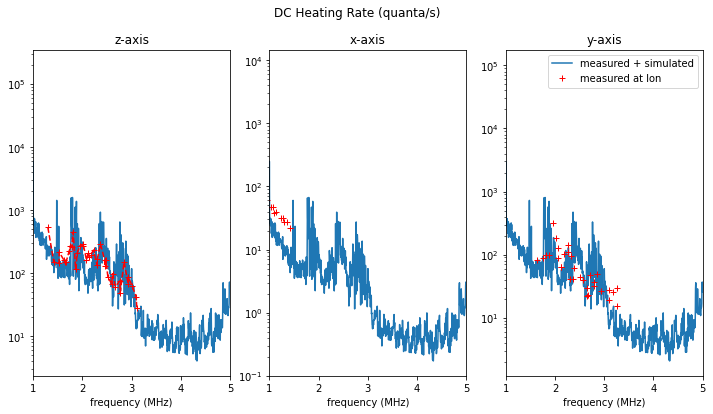

In [179]:

## Plotting Data 

fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='measured + simulated')
#ax[0].semilogy(frequency_array_meas, heating_rates_meas_rc_z,label ='RC')
#ax[0].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_z, label ='RC PCB')
ax[0].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = '+', color = 'r')
#ax[0].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
#ax[0].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[0].set_title('z-axis')


ax[1].semilogy(frequency_array_meas, heating_rates_measfb_x, label ='measured + simulated')
#ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_x,label ='RC')
#ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_x, label ='DAC + FB')
ax[1].semilogy(frequency_x, HR_x, label ='measured at Ion', linestyle = '', marker = '+', color = 'r')
#ax[1].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_x, 10),'+' ,label='Noise Floor')
#ax[1].fill_between(frequency_array_meas, heating_rates_gnd_meas_x,step="pre", alpha=0.4)
ax[1].set_title('x-axis')


ax[2].semilogy(frequency_array_meas, heating_rates_measfb_y, label ='measured + simulated')
#ax[2].semilogy(frequency_array_meas, heating_rates_meas_rc_y,label ='RC')
#ax[2].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_y, label ='RC PCB')
ax[2].semilogy(frequency_y, HR_y, label ='measured at Ion', linestyle = '', marker = '+', color = 'r')
#ax[2].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_y, 10),'+' ,label='Noise Floor')
#ax[2].fill_between(frequency_array_meas, heating_rates_gnd_meas_y,step="pre", alpha=0.4)
ax[2].set_title('y-axis')

fig.suptitle('DC Heating Rate (quanta/s)')
for a in ax.flat:
    a.set(xlabel='frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)
    a.set_xlim(1e6, 5e6)


plt.legend()
plt.show()

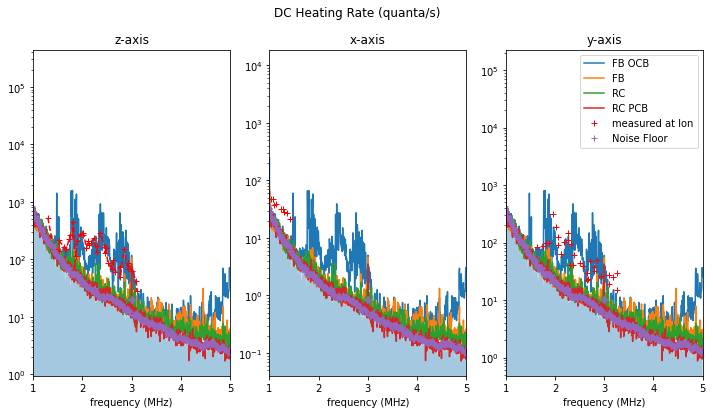

In [181]:

## Plotting Data 

fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='FB OCB')
ax[0].semilogy(frequency_array_meas, heating_rates_measfb_seperate_z, label ='FB')
ax[0].semilogy(frequency_array_meas, heating_rates_meas_rc_z,label ='RC')
ax[0].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_z, label ='RC PCB')
#ax[0].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_z, label ='ethernet ')
#ax[0].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_z, label ='ethernet disconnected')
ax[0].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = '+', color = 'r')
ax[0].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
ax[0].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[0].set_title('z-axis')


ax[1].semilogy(frequency_array_meas, heating_rates_measfb_x, label ='FB OCB')
ax[1].semilogy(frequency_array_meas, heating_rates_measfb_seperate_x, label ='FB')
ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_x,label ='RC')
ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_x, label ='RC PCB')
#ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_x, label ='ethernet ')
#ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_x, label ='ethernet disconnected')
ax[1].semilogy(frequency_x, HR_x, label ='measured at Ion', linestyle = '', marker = '+', color = 'r')
ax[1].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_x, 10),'+' ,label='Noise Floor')
ax[1].fill_between(frequency_array_meas, heating_rates_gnd_meas_x,step="pre", alpha=0.4)
ax[1].set_title('x-axis')


ax[2].semilogy(frequency_array_meas, heating_rates_measfb_y, label ='FB OCB')
ax[2].semilogy(frequency_array_meas, heating_rates_measfb_seperate_y, label ='FB')
ax[2].semilogy(frequency_array_meas, heating_rates_meas_rc_y,label ='RC')
ax[2].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_y, label ='RC PCB')
#ax[2].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_y, label ='ethernet ')
#ax[2].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_y, label ='ethernet disconnected')
ax[2].semilogy(frequency_y, HR_y, label ='measured at Ion', linestyle = '', marker = '+', color = 'r')
ax[2].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_y, 10),'+' ,label='Noise Floor')
ax[2].fill_between(frequency_array_meas, heating_rates_gnd_meas_y,step="pre", alpha=0.4)
ax[2].set_title('y-axis')

fig.suptitle('DC Heating Rate (quanta/s)')
for a in ax.flat:
    a.set(xlabel='frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)
    a.set_xlim(1e6, 5e6)


plt.legend()
plt.show()

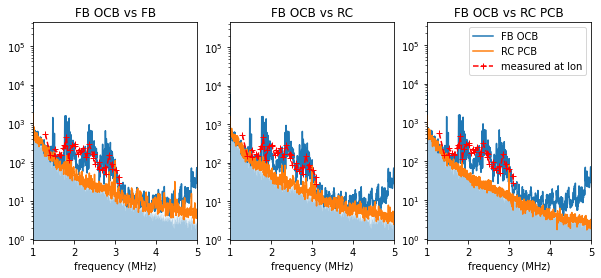

In [192]:
fig1, ax = plt.subplots(1,3, figsize=(10,4))

ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='FB OCB')
ax[0].semilogy(frequency_array_meas, heating_rates_measfb_seperate_z, label ='FB')
ax[0].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = '+', color = 'r')
#ax[0,0].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
ax[0].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[0].set_title('FB OCB vs FB')

ax[1].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='FB OCB')
ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_z,label ='RC')
ax[1].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = '+', color = 'r')
#ax[0,1].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
ax[1].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[1].set_title('FB OCB vs RC')

ax[2].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='FB OCB')
ax[2].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_z, label ='RC PCB')
ax[2].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = '+', color = 'r')
#ax[0,2].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
ax[2].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[2].set_title('FB OCB vs RC PCB')
"""
fig2, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='FB OCB')
ax[0].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_y, label ='ethernet ')
ax[0].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = '+', color = 'r')
#ax[1,0].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
ax[0].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[0].set_title('FB OCB ethernet')

ax[1].semilogy(frequency_array_meas, heating_rates_measfb_z, label ='FB OCB')
ax[1].semilogy(frequency_array_meas, heating_rates_meas_rc_pcb_y, label ='ethernet disconnected')
ax[1].semilogy(frequency_z, HR_z, label ='measured at Ion', linestyle = '--', marker = '+', color = 'r')
#ax[1,1].semilogy(moving_average(frequency_array_meas, 10), moving_average(heating_rates_gnd_meas_z, 10),'+' ,label='Noise Floor')
ax[1].fill_between(frequency_array_meas, heating_rates_gnd_meas_z,step="pre", alpha=0.4)
ax[1].set_title('FB OCB ethernet disconnected')
"""
fig.suptitle('DC Heating Rate (quanta/s) : z-axis')
for a in ax.flat:
    a.set(xlabel='frequency (MHz)')
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*10**(-6)))
    a.xaxis.set_major_formatter(ticks)
    a.set_xlim(1e6, 5e6)


plt.legend()
plt.show()

In [199]:
np.sqrt((50*0.001/(24.4141))*(10**((-68)/10)))

1.8016260079509085e-05